In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# ***EDA***

In [5]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<Axes: >

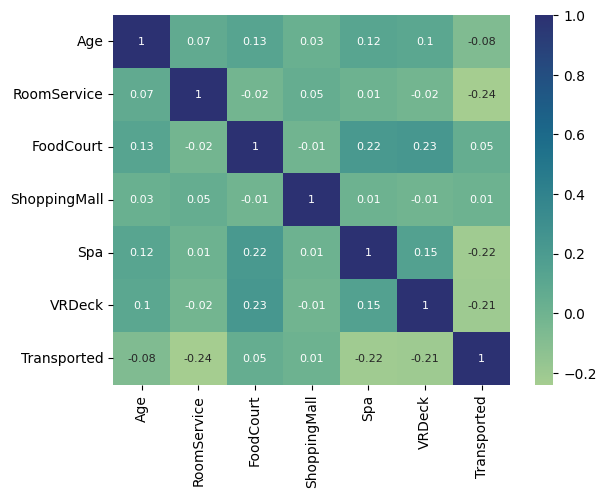

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt 

num = df.select_dtypes(include=['float64', 'bool'])
num_corr = round(num.corr(), 2)
sns.heatmap(num_corr, cmap='crest', annot=True, annot_kws={"size": 8})

Shopping mall does not seem to be correlated with the reponse. No transformations come to mind in that regard, which means we'll likely end up dropping that feature. 

# ***FEATURE ENGINEERING***

First, we can see that there is a stark difference between deck type and proportion of transported passengers:

In [9]:
df['Deck'] = df['Cabin'].str.split('/').str[0]

df.groupby('Deck')['Transported'].mean()

Deck
A    0.496094
B    0.734275
C    0.680054
D    0.433054
E    0.357306
F    0.439871
G    0.516217
T    0.200000
Name: Transported, dtype: float64

This tells us that target encoding might be effective. 

In [10]:
# Map each deck category with their "transported rate"
deck_transported_freq = {
    'E': 1,
    'T': 1, 
    'A': 2, 
    'D': 2, 
    'F': 2,
    'G': 2, 
    'B': 3, 
    'C': 3
}

df['DeckClass'] = df['Deck'].map(deck_transported_freq)

In [11]:
# The same applies to the passenger's Destination
destination_transported_freq = {
    'TRAPPIST-1e': 1, 
    'PSO J318.5-22': 2, 
    '55 Cancri e': 3,
}

df['Destination'] = df['Destination'].map(destination_transported_freq)

In [12]:
test['Deck'] = test['Cabin'].str.split('/').str[0]
test['DeckClass'] = test['Deck'].map(deck_transported_freq)

test['Destination'] = test['Destination'].map(destination_transported_freq)

# ***PREPROCESSING***

In [13]:
X = df.drop(['Transported', 'PassengerId', 'Cabin', 'ShoppingMall', 'Name', 'Deck'], axis=1)
y = df['Transported']

In [14]:
test_sub = test.drop(['PassengerId', 'Cabin', 'ShoppingMall', 'Name', 'Deck'], axis=1)

In [15]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'Spa', 'VRDeck', 'DeckClass'],
      dtype='object')

In [16]:
test_sub.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'Spa', 'VRDeck', 'DeckClass'],
      dtype='object')

In [17]:
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

# Select numerical features 
num_features = X.select_dtypes(include='float64').columns
# Select categorical features 
cat_features = X.select_dtypes(include='object').columns

# Impute median to all numerical features 
num_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy='median')),
    ("scale", RobustScaler())
])

# Impute most frequent category to all categorical features
cat_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

In [18]:
# Fit data matrix X under the above contraints
X = preprocessor.fit_transform(X)

In [19]:
test_sub = preprocessor.fit_transform(test_sub)

# ***FITTING***

In [20]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression()

results = cross_val_score(model, X, y, scoring='accuracy', cv=10)
results.mean()

0.7830469690356202

In [21]:
model.fit(X, y) 

LogisticRegression()

In [22]:
test['Transported'] = model.predict(test_sub)

In [23]:
submission = test[['PassengerId', 'Transported']]

In [26]:
submission.to_csv('submission.csv', index=False)